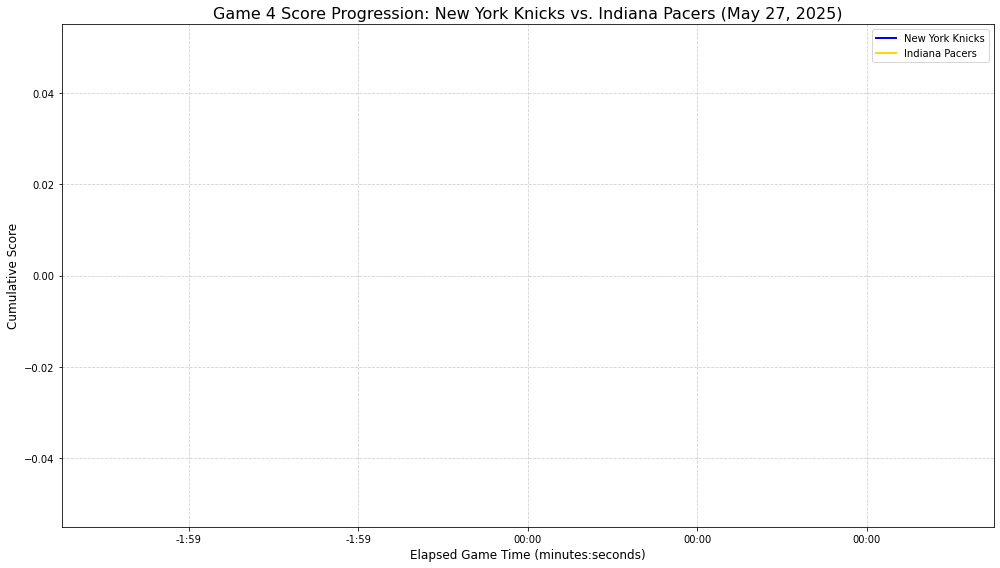

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

HTML_FILE_PATH = 'Example_game.html'
# Assume HTML_FILE_PATH is an existing variable for the HTML file
# Open the HTML file and parse its content
with open(HTML_FILE_PATH, encoding="utf-8") as f:
    soup = BeautifulSoup(f, "lxml")

# Locate the play-by-play table using its unique ID
pbp_table = soup.find('table', {'id': 'pbp'})

# Prepare empty lists to store the extracted and processed data points
all_elapsed_times_seconds = []
knicks_cumulative_scores = []
pacers_cumulative_scores = []

# Define the standard duration of an NBA quarter in seconds
NBA_QUARTER_DURATION_SECONDS = 12 * 60 # 12 minutes per quarter

# Initialize a variable to keep track of the total time elapsed from the start of the game
# This offset will be updated at the beginning of each new quarter
current_quarter_time_offset_seconds = 0

# Iterate through each table row found within the play-by-play table
for row in pbp_table.find_all('tr'):
    # Check if the current row is a quarter header (e.g., <tr class='thead' id="q1">)
    # These rows indicate the start of a new quarter and are used to adjust the time offset
    if 'id' in row.attrs and row.attrs['id'].startswith('q'):
        # Extract the quarter number from the ID (e.g., 'q1' -> 1, 'q2' -> 2)
        quarter_number = int(row.attrs['id'][1])
        # Calculate the total time elapsed from previous quarters
        current_quarter_time_offset_seconds = (quarter_number - 1) * NBA_QUARTER_DURATION_SECONDS
        continue # Skip to the next row as this is not a data entry

    # Attempt to find the 'Time' and 'Score' cells within the current row
    # Note: In the provided HTML, 'Time' is in a <th> for data rows, not <td>
    time_cell = row.find('th', {'data-stat': 'Time'})
    score_cell = row.find('td', {'data-stat': 'Score'})

    # Ensure both cells exist and are not the table's main header row (which has 'Time' as text)
    # Rows like "Jump ball" or "End of quarter" do not have a 'Score' data-stat cell,
    # so score_cell will be None and these rows will be correctly skipped.
    if time_cell and score_cell and time_cell.text.strip() != 'Time':
        time_str = time_cell.text.strip()
        score_str = score_cell.text.strip()

        # Convert the 'MM:SS.0' time string into seconds remaining in the current quarter
        minutes, seconds_decimal = map(float, time_str.split(':'))
        time_remaining_in_current_quarter_seconds = (minutes * 60) + seconds_decimal

        # Calculate the total elapsed game time by adding the quarter offset
        # The time in the PBP table counts down, so subtract from the quarter duration
        elapsed_in_current_quarter = NBA_QUARTER_DURATION_SECONDS - time_remaining_in_current_quarter_seconds
        total_elapsed_game_seconds = current_quarter_time_offset_seconds + elapsed_in_current_quarter

        # Split the score string (e.g., "121-130") into individual team scores
        # The HTML shows "NYK-IND" format, so Knicks score is first, Pacers second.
        knicks_score, pacers_score = map(int, score_str.split('-'))

        # Append the calculated data to their respective lists
        all_elapsed_times_seconds.append(total_elapsed_game_seconds)
        knicks_cumulative_scores.append(knicks_score)
        pacers_cumulative_scores.append(pacers_score)

# Create a Pandas DataFrame from the collected data
game_score_data = pd.DataFrame({
    'Elapsed Time (seconds)': all_elapsed_times_seconds,
    'New York Knicks Score': knicks_cumulative_scores,
    'Indiana Pacers Score': pacers_cumulative_scores
})

# Generate the Line Chart visualization using Matplotlib
# Create a figure and a set of subplots (in this case, one subplot)
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the score progression for the New York Knicks
ax.plot(game_score_data['Elapsed Time (seconds)'].values, game_score_data['New York Knicks Score'].values,
        label='New York Knicks', color='blue', linewidth=2)

# Plot the score progression for the Indiana Pacers
ax.plot(game_score_data['Elapsed Time (seconds)'].values, game_score_data['Indiana Pacers Score'].values,
        label='Indiana Pacers', color='gold', linewidth=2)

# Set the title of the chart for clarity
ax.set_title('Game 4 Score Progression: New York Knicks vs. Indiana Pacers (May 27, 2025)', fontsize=16)

# Label the x-axis (Elapsed Game Time)
ax.set_xlabel('Elapsed Game Time (minutes:seconds)', fontsize=12)

# Label the y-axis (Cumulative Score)
ax.set_ylabel('Cumulative Score', fontsize=12)

# Add a legend to differentiate between the two teams' lines
ax.legend(fontsize=10)

# Add a grid to the plot for easier reading of values
ax.grid(True, linestyle='--', alpha=0.6)

# Optional: Improve x-axis tick labels to display time in MM:SS format
# Define a function to format seconds into minutes:seconds string
def format_seconds_to_mmss(seconds, position):
    minutes = int(seconds // 60)
    remaining_seconds = int(seconds % 60)
    return f"{minutes:02d}:{remaining_seconds:02d}"

# Apply the custom formatter to the x-axis major ticks
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_seconds_to_mmss))

# Adjust the layout to ensure all elements fit without overlapping
fig.tight_layout()

In [3]:
game_score_data

,Elapsed Time (seconds),New York Knicks Score,Indiana Pacers Score
